# Libraries

In [4]:
!pip install textblob

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 626.3/626.3 kB 11.6 MB/s eta 0:00:00


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
import xgboost as xgb
from scipy.sparse import hstack
from textblob import TextBlob
from os.path import exists

# Loading the Files

Download the csv files into the `data/` directory.

In [5]:
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print(trainingSet.head(3))


print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)
        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   

   HelpfulnessDenominator        Time                             Summary  \
0                       2  1341014400                       GOOD FUN FILM   
1                       0  1168819200                        Movie Review   
2                       0  1386201600  When is it a good time to Consent?   

                                                Text  Score  
0  While most straight to DVD films are not worth...    5.0  
1  I have wanted this one for sometime, also.  I ...    5.0  
2  Actually this was a pretty darn good indie fil...    4.0  

EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


# Feature

In [21]:
def add_features_to(df):
    # Feature 1: Helpfulness ratio
    df['Helpfulness'] = df['HelpfulnessNumerator'] / (df['HelpfulnessDenominator'] + 1)
    df['Helpfulness'] = df['Helpfulness'].fillna(0)

    # Feature 2: Length of the review text (in words and characters)
    df['ReviewLengthWords'] = df['Text'].apply(lambda x: len(str(x).split()))
    df['ReviewLengthChars'] = df['Text'].apply(lambda x: len(str(x)))

    # Feature 3: Length of the summary text (in words and characters)
    df['SummaryLengthWords'] = df['Summary'].apply(lambda x: len(str(x).split()))
    df['SummaryLengthChars'] = df['Summary'].apply(lambda x: len(str(x)))

    # Feature 4: Time-based features from the timestamp (extract year and month)
    df['ReviewYear'] = pd.to_datetime(df['Time'], unit='s').dt.year
    df['ReviewMonth'] = pd.to_datetime(df['Time'], unit='s').dt.month

    # Feature 5: Sentiment score of the review text
    df['SentimentScore'] = df['Text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

    # Feature 6: Lexical richness (unique words / total words)
    df['LexicalRichness'] = df['Text'].apply(lambda x: len(set(str(x).split())) / len(str(x).split()) if len(str(x).split()) > 0 else 0)

    # Feature 7: Exclamation mark count in the review text
    df['ExclamationCount'] = df['Text'].apply(lambda x: str(x).count('!'))

    # Fill missing values (if any) in new features
    df = df.fillna(0)

    return df

# 加载已经提取的特征文件（如果存在）
if exists('X_train.csv'):
    X_train = pd.read_csv("X_train.csv")
if exists('X_submission.csv'):
    X_submission = pd.read_csv("X_submission.csv")

else:
    # 对训练集添加特征
    train = add_features_to(trainingSet)

    # 合并测试集以便应用相同的特征工程
    X_submission = pd.merge(train, testingSet, on='Id', how='left')

    # 处理重复的 'Score' 列并重命名
    X_submission = X_submission.drop(columns=['Score_x'])
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})

    # 创建训练集，仅包含评分不为空的行
    X_train = train[train['Score'].notnull()]

    # 保存处理后的文件以备将来使用
    X_submission.to_csv("X_submission.csv", index=False)
    X_train.to_csv("X_train.csv", index=False)

# Model


In [24]:
!pip install --upgrade xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 8.5 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.1.1
    Uninstalling xgboost-2.1.1:
      Successfully uninstalled xgboost-2.1.1


In [23]:
# Step 1: Sample the data
sampled_df = trainingSet.sample(frac=0.2, random_state=42)

# 确保 'Text' 和 'Summary' 列都是字符串格式
sampled_df['Text'] = sampled_df['Text'].astype(str)
sampled_df['Summary'] = sampled_df['Summary'].astype(str)

# Step 2: 应用特征工程
sampled_df = add_features_to(sampled_df)

# 使用 TF-IDF 对 'Text' 和 'Summary' 列进行向量化
tfidf_text = TfidfVectorizer(max_features=8000)
train_text_tfidf = tfidf_text.fit_transform(sampled_df['Text'].fillna(''))

tfidf_summary = TfidfVectorizer(max_features=3000)
train_summary_tfidf = tfidf_summary.fit_transform(sampled_df['Summary'].fillna(''))

# 组合数值特征
numeric_features = sampled_df[['Helpfulness', 'ReviewLengthWords', 'ReviewLengthChars',
                               'SummaryLengthWords', 'SummaryLengthChars',
                               'ReviewYear', 'ReviewMonth', 'SentimentScore',
                               'LexicalRichness', 'ExclamationCount']].fillna(0)

# 将 TF-IDF 特征与数值特征组合
X = hstack([train_text_tfidf, train_summary_tfidf, numeric_features.values])
y = sampled_df['Score'].fillna(0)

# Step 3: 将数据划分为训练集和验证集
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: 训练 XGBoost 模型
xgb_model = xgb.XGBClassifier(
    n_estimators=500,  # 减少估计器数量以加快训练
    learning_rate=0.1,
    max_depth=6,
    min_child_weight=3,
    gamma=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# 无早停机制，直接训练
xgb_model.fit(X_train, y_train)

# Step 5: 评估模型
y_pred = xgb_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f'XGBoost Accuracy on Sampled Data: {accuracy}')

XGBoost Accuracy on Sampled Data: 0.5723542752790787


# Model Evaluation

Accuracy on testing set = 0.5723542752790787


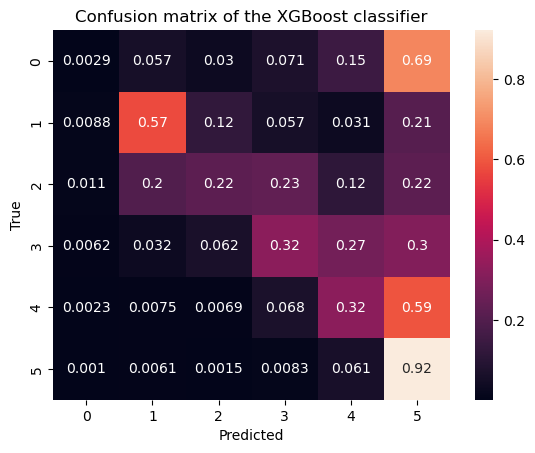

In [25]:
# Print accuracy score
print(f'Accuracy on testing set = {accuracy_score(y_val, y_pred)}')

# Plot confusion matrix
cm = confusion_matrix(y_val, y_pred, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the XGBoost classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


# File make

In [68]:
# Prepare Submission File
submission_text_tfidf = tfidf_text.transform(X_submission['Text'].fillna(''))
submission_summary_tfidf = tfidf_summary.transform(X_submission['Summary'].fillna(''))

submission_numeric_features = X_submission[['Helpfulness', 'ReviewLengthWords', 'ReviewLengthChars',
                                            'SummaryLengthWords', 'SummaryLengthChars',
                                            'ReviewYear', 'ReviewMonth', 'SentimentScore',
                                            'LexicalRichness', 'ExclamationCount']].fillna(0)

X_submission_select = hstack([submission_text_tfidf, submission_summary_tfidf, submission_numeric_features.values])

X_submission['Score'] = xgb_model.predict(X_submission_select).round().astype(int)
X_submission['Score'] = X_submission['Score'].clip(1, 5)

submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)

print("Submission file created: ./data/submission.csv")

Submission file created: ./data/submission.csv
